In [1]:
from pathlib import Path
import shutil
import os
import gc

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import cv2
from numpy.random import default_rng

import torch
from torch.utils.data import Dataset
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchmetrics.functional.classification import f1_score
from torchmetrics import Dice

import pytorch_lightning as pl
from torchvision.models import vgg19, VGG19_Weights, vgg11, VGG11_Weights

from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.callbacks import ModelCheckpoint

from torchvision import transforms
import albumentations as A
from albumentations.pytorch import ToTensorV2

from tqdm import tqdm

# from kaggle_secrets import UserSecretsClient
import wandb

/tmp/ipykernel_125242/3984751441.py:6: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
DS_DIR = Path('/home/viktor/PythonProjects/data/airbus-ship-detection/')

In [3]:
train_df = pd.read_csv(DS_DIR/'train_ship_segmentations_v2.csv')
train_df.head()

ImageId                                      EncodedPixels
0  00003e153.jpg                                                NaN
1  0001124c7.jpg                                                NaN
2  000155de5.jpg  264661 17 265429 33 266197 33 266965 33 267733...
3  000194a2d.jpg  360486 1 361252 4 362019 5 362785 8 363552 10 ...
4  000194a2d.jpg  51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...

Get summary of dataset metadata.

In [4]:
train_df.describe()

ImageId                                      EncodedPixels
count          231723                                              81723
unique         192556                                              81722
top     e6fd0c12e.jpg  43801 1 44567 4 45334 5 46100 8 46867 9 47636 ...
freq               15                                                  2

In [6]:
count_df = train_df['ImageId'].value_counts().reset_index()
count_df[count_df['count'] > 1]

ImageId  count
0      e6fd0c12e.jpg     15
1      2053a78bd.jpg     15
2      d3c47b3d3.jpg     15
3      4de149bd9.jpg     15
4      c8e722430.jpg     15
...              ...    ...
15447  91181b28b.jpg      2
15448  f2b136504.jpg      2
15449  018c4ba23.jpg      2
15450  bc9a69821.jpg      2
15451  92228cc6d.jpg      2

[15452 rows x 2 columns]

There are different values of EncodedPixels for the same ImageId. Maybe, each encoded object mask is a separate row. We will see it later.

Check for simple duplicates.

In [6]:
train_df[train_df.duplicated()]

Empty DataFrame
Columns: [ImageId, EncodedPixels]
Index: []

As it is impossible do an EDA of image dataset without visualizations, let's load an image and then load its mask.

/home/viktor/PythonProjects/data/airbus-ship-detection/train_v2/000155de5.jpg


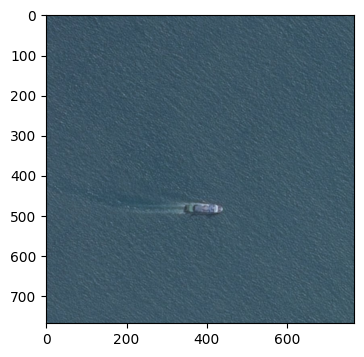

In [8]:
p = str(DS_DIR/'train_v2'/train_df['ImageId'][2])
print(p)
img = cv2.imread(p)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(4,4))
plt.imshow(img)
plt.show()

Checked image existence:
![Image existence](./eda_images/image_existence.png)

In [9]:
# possible improvement: https://www.kaggle.com/code/paulorzp/run-length-encode-and-decode/script
def get_mask(img_id):
    h, w = img.shape[:2]
    mask = np.zeros(img.shape[:2])
    encoded_pixels_list = list(train_df[train_df['ImageId'] == img_id]['EncodedPixels'])
    for encoded_pixels in encoded_pixels_list:
        if isinstance(encoded_pixels, float) and np.isnan(encoded_pixels):
            continue
        encoded_pixels = list(map(int, encoded_pixels.split(' ')))
        for i in range(int(len(encoded_pixels)/2)):
            ran = np.arange(encoded_pixels[i*2+1])
            ran = ran + encoded_pixels[i*2]
            for num in ran:
                num = num-1
                col = num//h
                row = num - h*col
                mask[row][col] = 255
    return mask

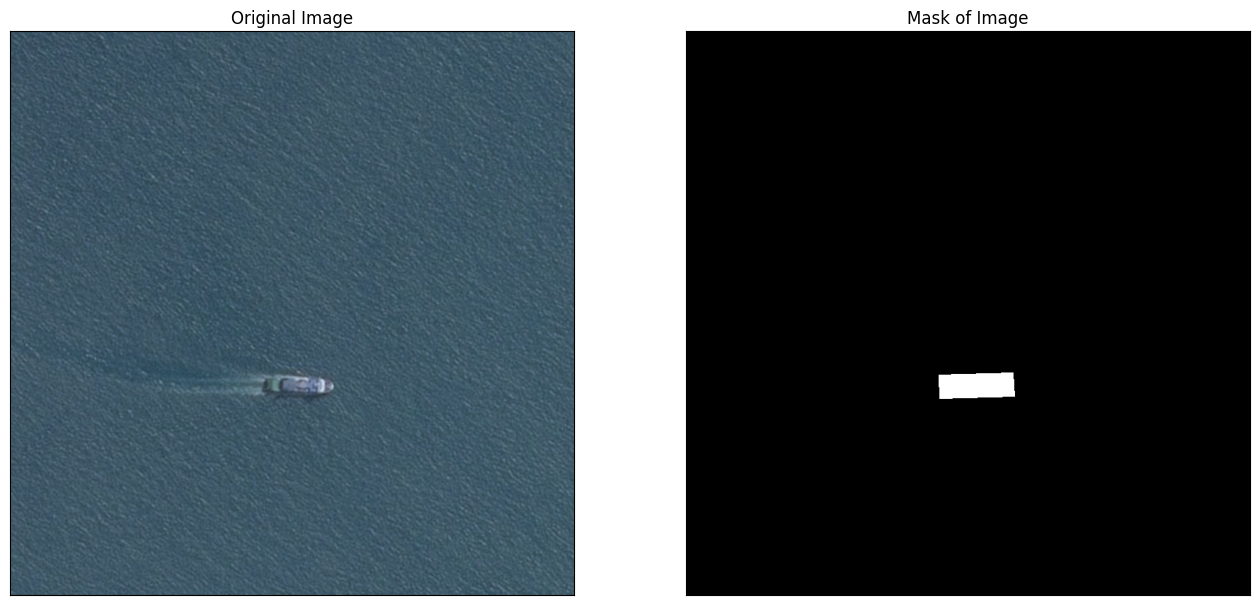

In [10]:
mask = get_mask(train_df['ImageId'][2])

plt.figure(figsize=(16,8))
plt.subplot(121),plt.imshow(img)
plt.title('Original Image'), plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(mask,cmap = 'gray')
plt.title('Mask of Image'), plt.xticks([]), plt.yticks([])
plt.show()

Now we plot many different images with corresponding masks to get an overall sense of the data.

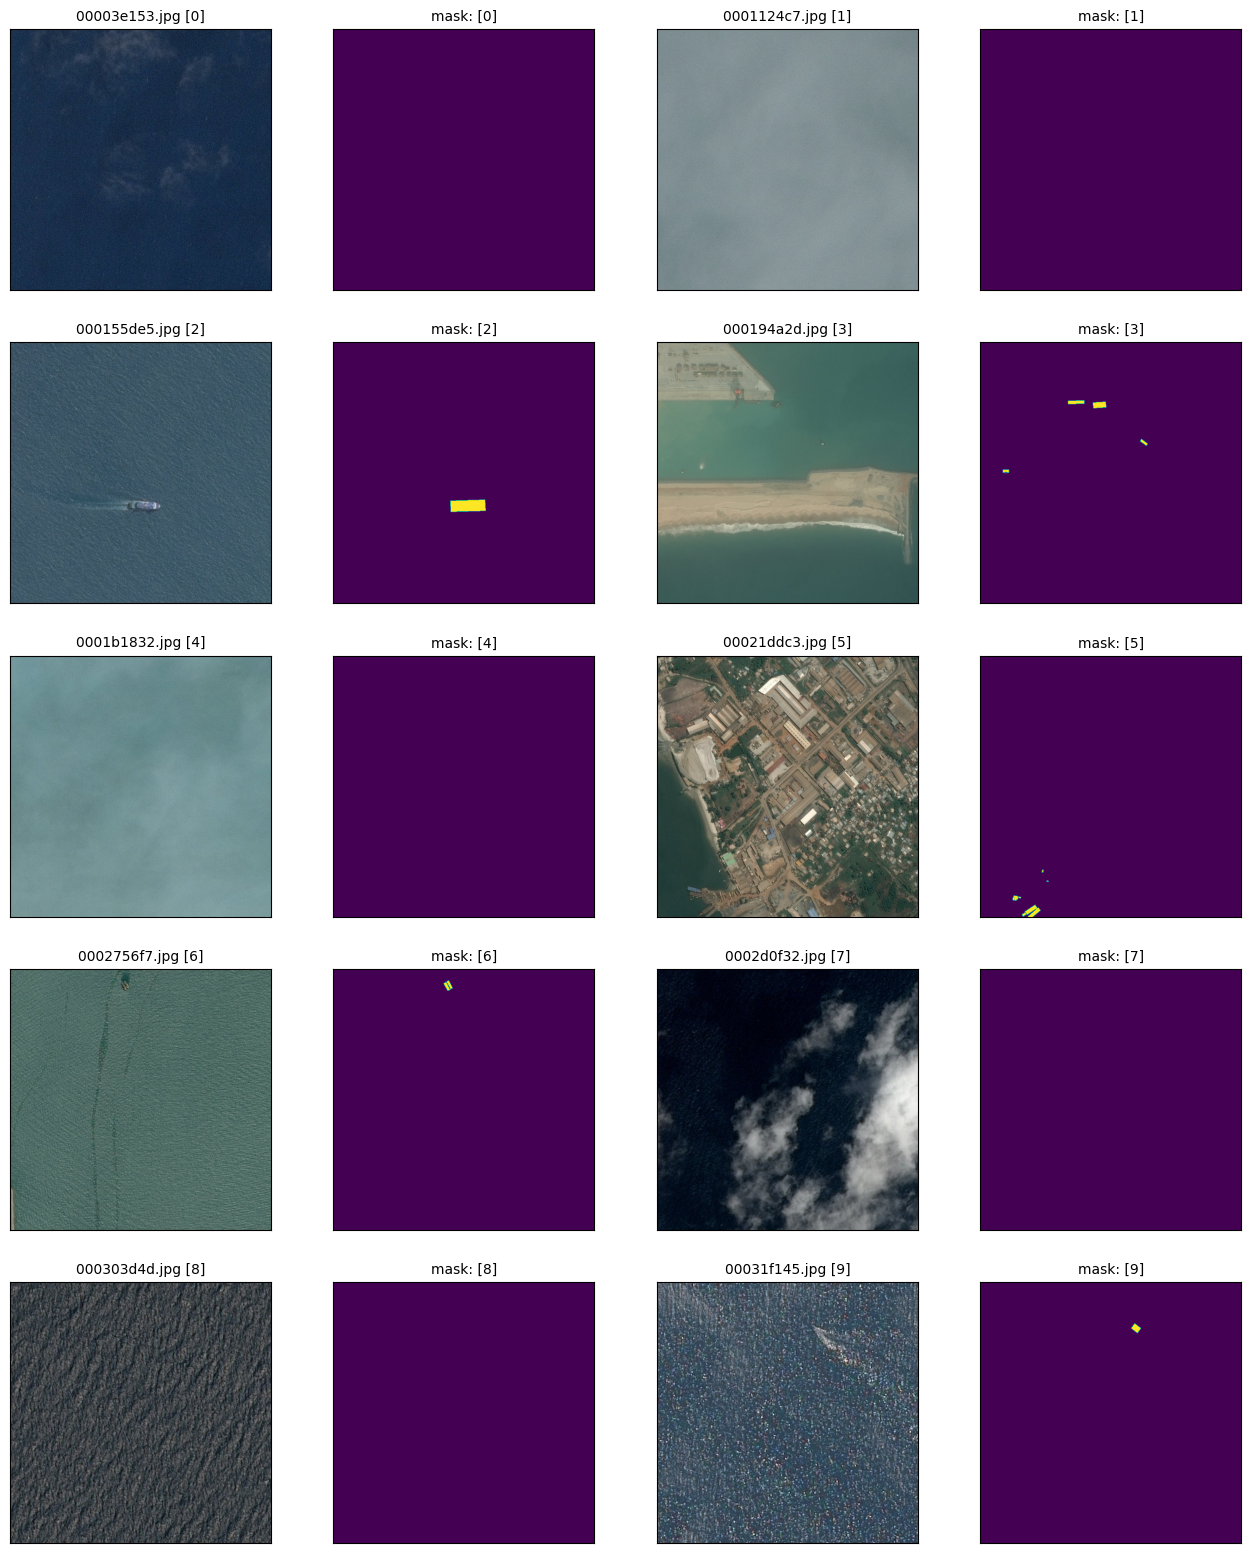

In [11]:
fig = plt.figure(figsize=(16, 40))
for idx, img_id in enumerate(list(train_df['ImageId'].unique())[:10]):
    img_path = DS_DIR/'train_v2'/img_id
    img = cv2.imread(str(img_path))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    ax = fig.add_subplot(10, 4, 2*idx+1, xticks=[], yticks=[])
    ax.imshow(img)
    ax.set_title(f'{img_path.name} [{idx}]', fontsize=10)
    
    mask = get_mask(img_id)
    ax = fig.add_subplot(10, 4, 2*idx+2, xticks=[], yticks=[])
    ax.imshow(mask)
    ax.set_title(f'mask: [{idx}]', fontsize=10)
plt.show()

From, the dialogue below we presume that size of all images is 768x768. But even more reliable way is to gather sizes of a random set of images.

![Dialogue image sizes](./eda_images/image_sizes_dialogue.png)

In [13]:
# sample images to check width and height
sample_size = 20000
unique_img_ids = train_df['ImageId'].unique()
sample_img_ids = np.random.choice(unique_img_ids, sample_size, replace=False)
len(sample_img_ids)

20000

In [ ]:
img_sizes_df = pd.DataFrame(columns=['ImageId', 'Width', 'Height'])
for img_id in tqdm(sample_img_ids):
    img = cv2.imread(str(DS_DIR/'train_v2'/img_id))
    img_sizes_df.loc[img_sizes_df.shape[0]] = [img_id, img.shape[1], img.shape[0]]

  0%|          | 0/20000 [00:00<?, ?it/s]

100%|██████████| 20000/20000 [02:36<00:00, 127.90it/s]


array([[<Axes: title={'center': 'Width'}>,
        <Axes: title={'center': 'Height'}>]], dtype=object)

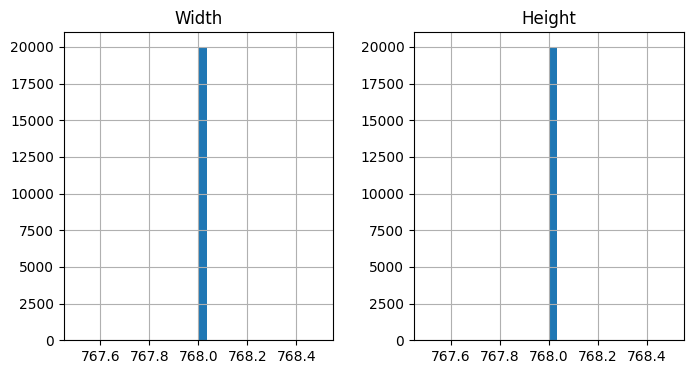

In [ ]:
img_sizes_df.hist(bins=30, figsize=(8, 4))

Analysis of number of objects per image shows us how many background images are there. And how annotations are distributed among images.

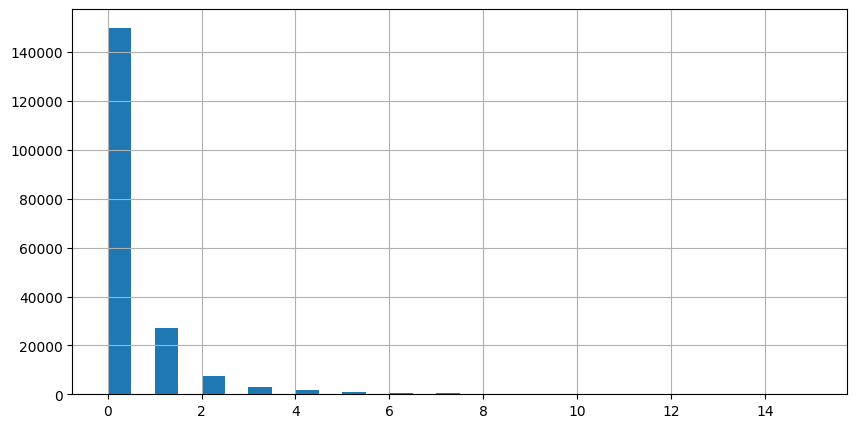

In [12]:
train_df['IsObject'] = train_df['EncodedPixels'].apply(lambda x: 0 if pd.isna(x) else 1)
num_objects_df = train_df.groupby('ImageId').agg({'IsObject': 'sum'}).reset_index()
num_objects_df['IsObject'].hist(bins=30, figsize=(10, 5))
plt.show()

As we can see, there are lots of background images. This type of photos shows model what is not a ship, but it doesn't teach model what it is. Large number of background images can potentially make model to identify almost anything as a non-ship. In other words, it may lead to many False Negatives.

We need to test whether these backgrounds appear to be a problem. One common way is to run 2 trainings of a model: one with all such images and another with a fraction of them. And the second approach is to give different weights to *background* and *ship* classes in a loss function. Or even another way is to use Focal Tversky Loss, according to this [paper](https://arxiv.org/abs/1810.07842).

By the way, let's check whether there is no redundant records for images with a few objects.

In [13]:
merged = train_df.groupby('ImageId').agg({'IsObject': 'sum'}).reset_index().merge(train_df['ImageId'].value_counts(), on='ImageId')
merged[(merged['count'] > merged['IsObject']) & (merged['IsObject'] != 0)]

Empty DataFrame
Columns: [ImageId, IsObject, count]
Index: []

We can also observe images with large number of objects.

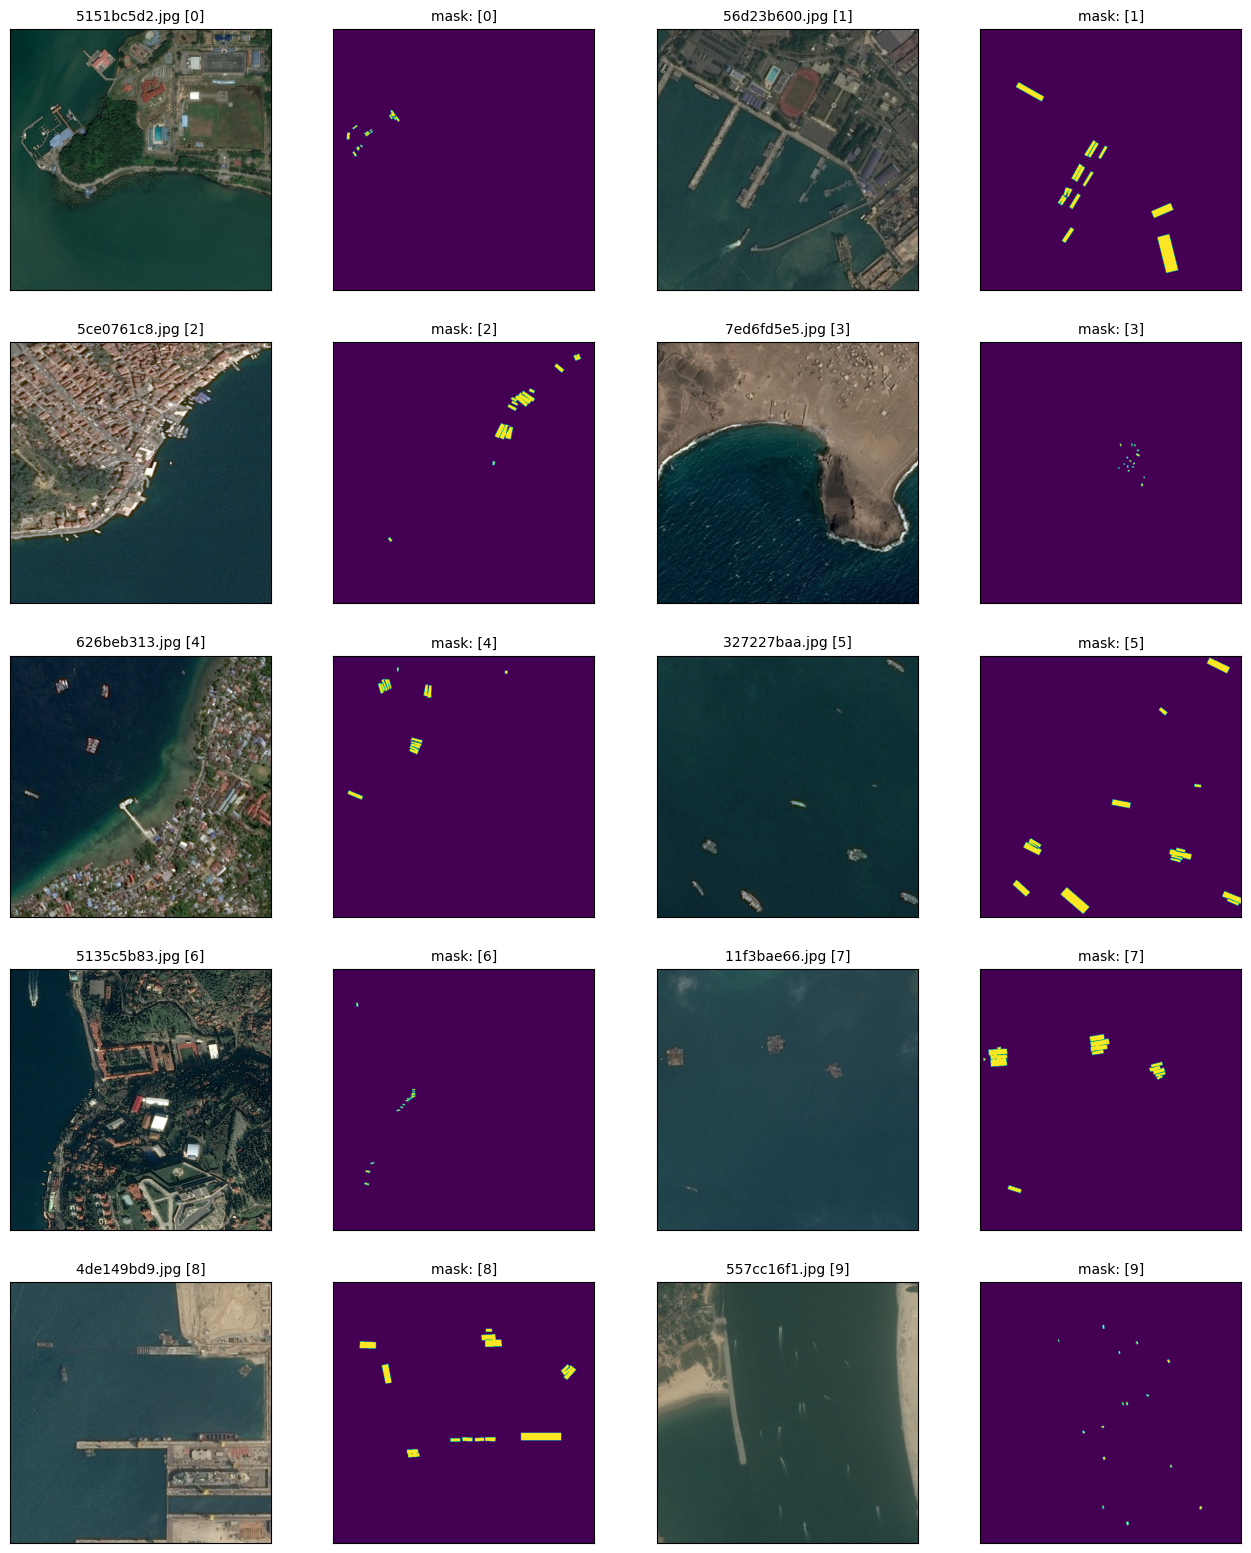

In [14]:
fig = plt.figure(figsize=(16, 40))
for idx, img_id in enumerate(list(num_objects_df.sort_values('IsObject', ascending=False)['ImageId'].unique())[:10]):
    img_path = DS_DIR/'train_v2'/img_id
    img = cv2.imread(str(img_path))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    ax = fig.add_subplot(10, 4, 2*idx+1, xticks=[], yticks=[])
    ax.imshow(img)
    ax.set_title(f'{img_path.name} [{idx}]', fontsize=10)
    
    mask = get_mask(img_id)
    ax = fig.add_subplot(10, 4, 2*idx+2, xticks=[], yticks=[])
    ax.imshow(mask)
    ax.set_title(f'mask: [{idx}]', fontsize=10)
plt.show()

The next step is a dictribution of area per object.

In [15]:
def get_obj_area(encoded_pixels):
    if isinstance(encoded_pixels, float) and np.isnan(encoded_pixels):
        return 0
    encoded_pixels = list(map(int, encoded_pixels.split(' ')))
    area = 0
    for i in range(int(len(encoded_pixels)/2)):
        area += encoded_pixels[i*2+1]
    return area

train_df['ObjArea'] = train_df['EncodedPixels'].apply(get_obj_area)

In [ ]:
train_df['ObjArea'][train_df['ObjArea'] == 0].count()

150000

We plot a distribution for records where  $area \ne 0$, so object exists.

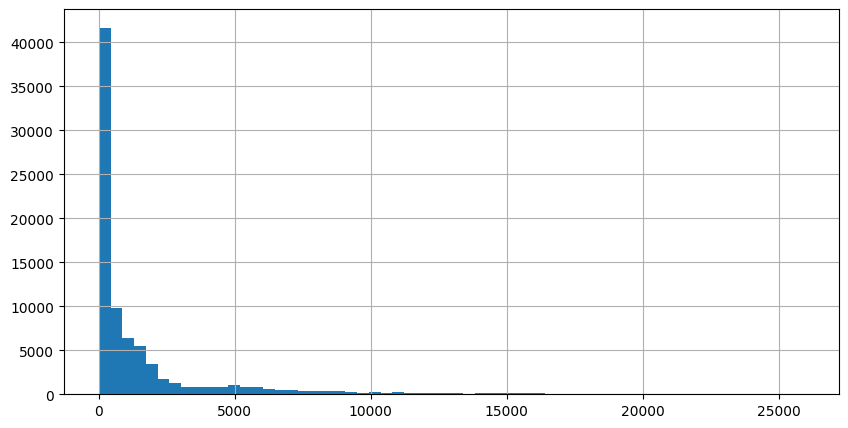

In [ ]:
ax = train_df['ObjArea'][train_df['ObjArea'] != 0].hist(bins=60, figsize=(10, 5))
plt.show()

In [ ]:
train_df['ObjArea'][train_df['ObjArea'] != 0].agg(['min', 'max', 'mean', 'median'])

min           2.000000
max       25904.000000
mean       1567.402849
median      408.000000
Name: ObjArea, dtype: float64

We can see that some masks are really enormous. Are these outliers bugs or just huge ships?

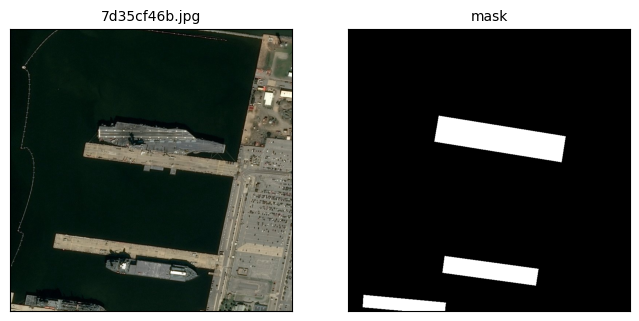

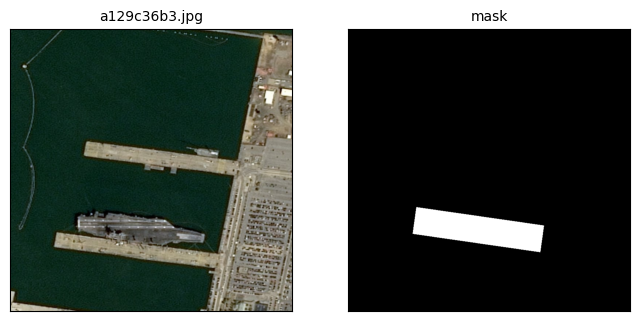

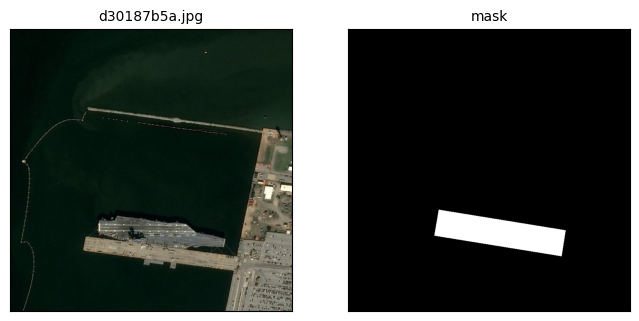

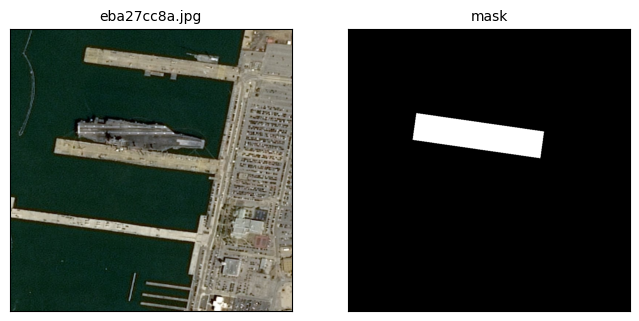

In [67]:
for img_id in train_df[train_df['ObjArea'] >= 25000]['ImageId']:
    img = cv2.imread(str(DS_DIR/'train_v2'/img_id))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    mask = get_mask(img_id)
    fig = plt.figure(figsize=(8, 4))
    ax = fig.add_subplot(1, 2, 1, xticks=[], yticks=[])
    ax.imshow(img)
    ax.set_title(f'{img_id}', fontsize=10)
    ax = fig.add_subplot(1, 2, 2, xticks=[], yticks=[])
    ax.imshow(mask, cmap='gray')
    ax.set_title(f'mask', fontsize=10)
    plt.show()

Then, we inspect the images with smaller object area and larger object area separately. Maybe, it will give us some insights. As you rarely know if something gives you a hint before you check it.

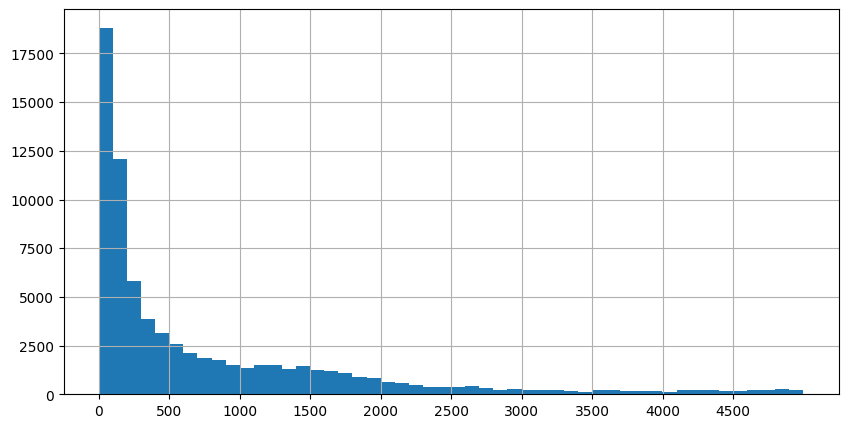

In [ ]:
# let's inspect the images with smaller object area
ax = train_df['ObjArea'][(train_df['ObjArea'] != 0) & (train_df['ObjArea'] < 5000)].hist(bins=50, figsize=(10, 5))
ax.set_xticks(range(0, 5000, 500))
plt.show()

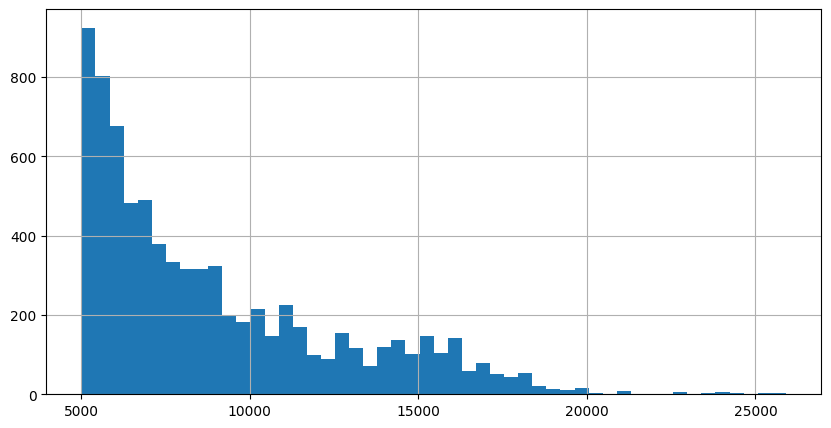

In [ ]:
# and with larger object area
ax = train_df['ObjArea'][(train_df['ObjArea'] != 0) & (train_df['ObjArea'] > 5000)].hist(bins=50, figsize=(10, 5))
plt.show()

Now let's apply some transformatios that are integral part of every data enhancement for model training in CV project. It makes data more diverse, so model becomes more robust to input data and segments objects more precisely.

I selected a few innocent transformations such as:
- Flip: drone may rotate and take a photo from different angle.
- ShiftScaleRotate: as drone may be closer to the surface of the sea.
- RandomBrightnessContrast: as it depends on camera quality and brightness of the sun.

In [35]:
transform = A.Compose(
    [
        A.Flip(),
        A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.15, rotate_limit=15),
        A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2),
    ]
)

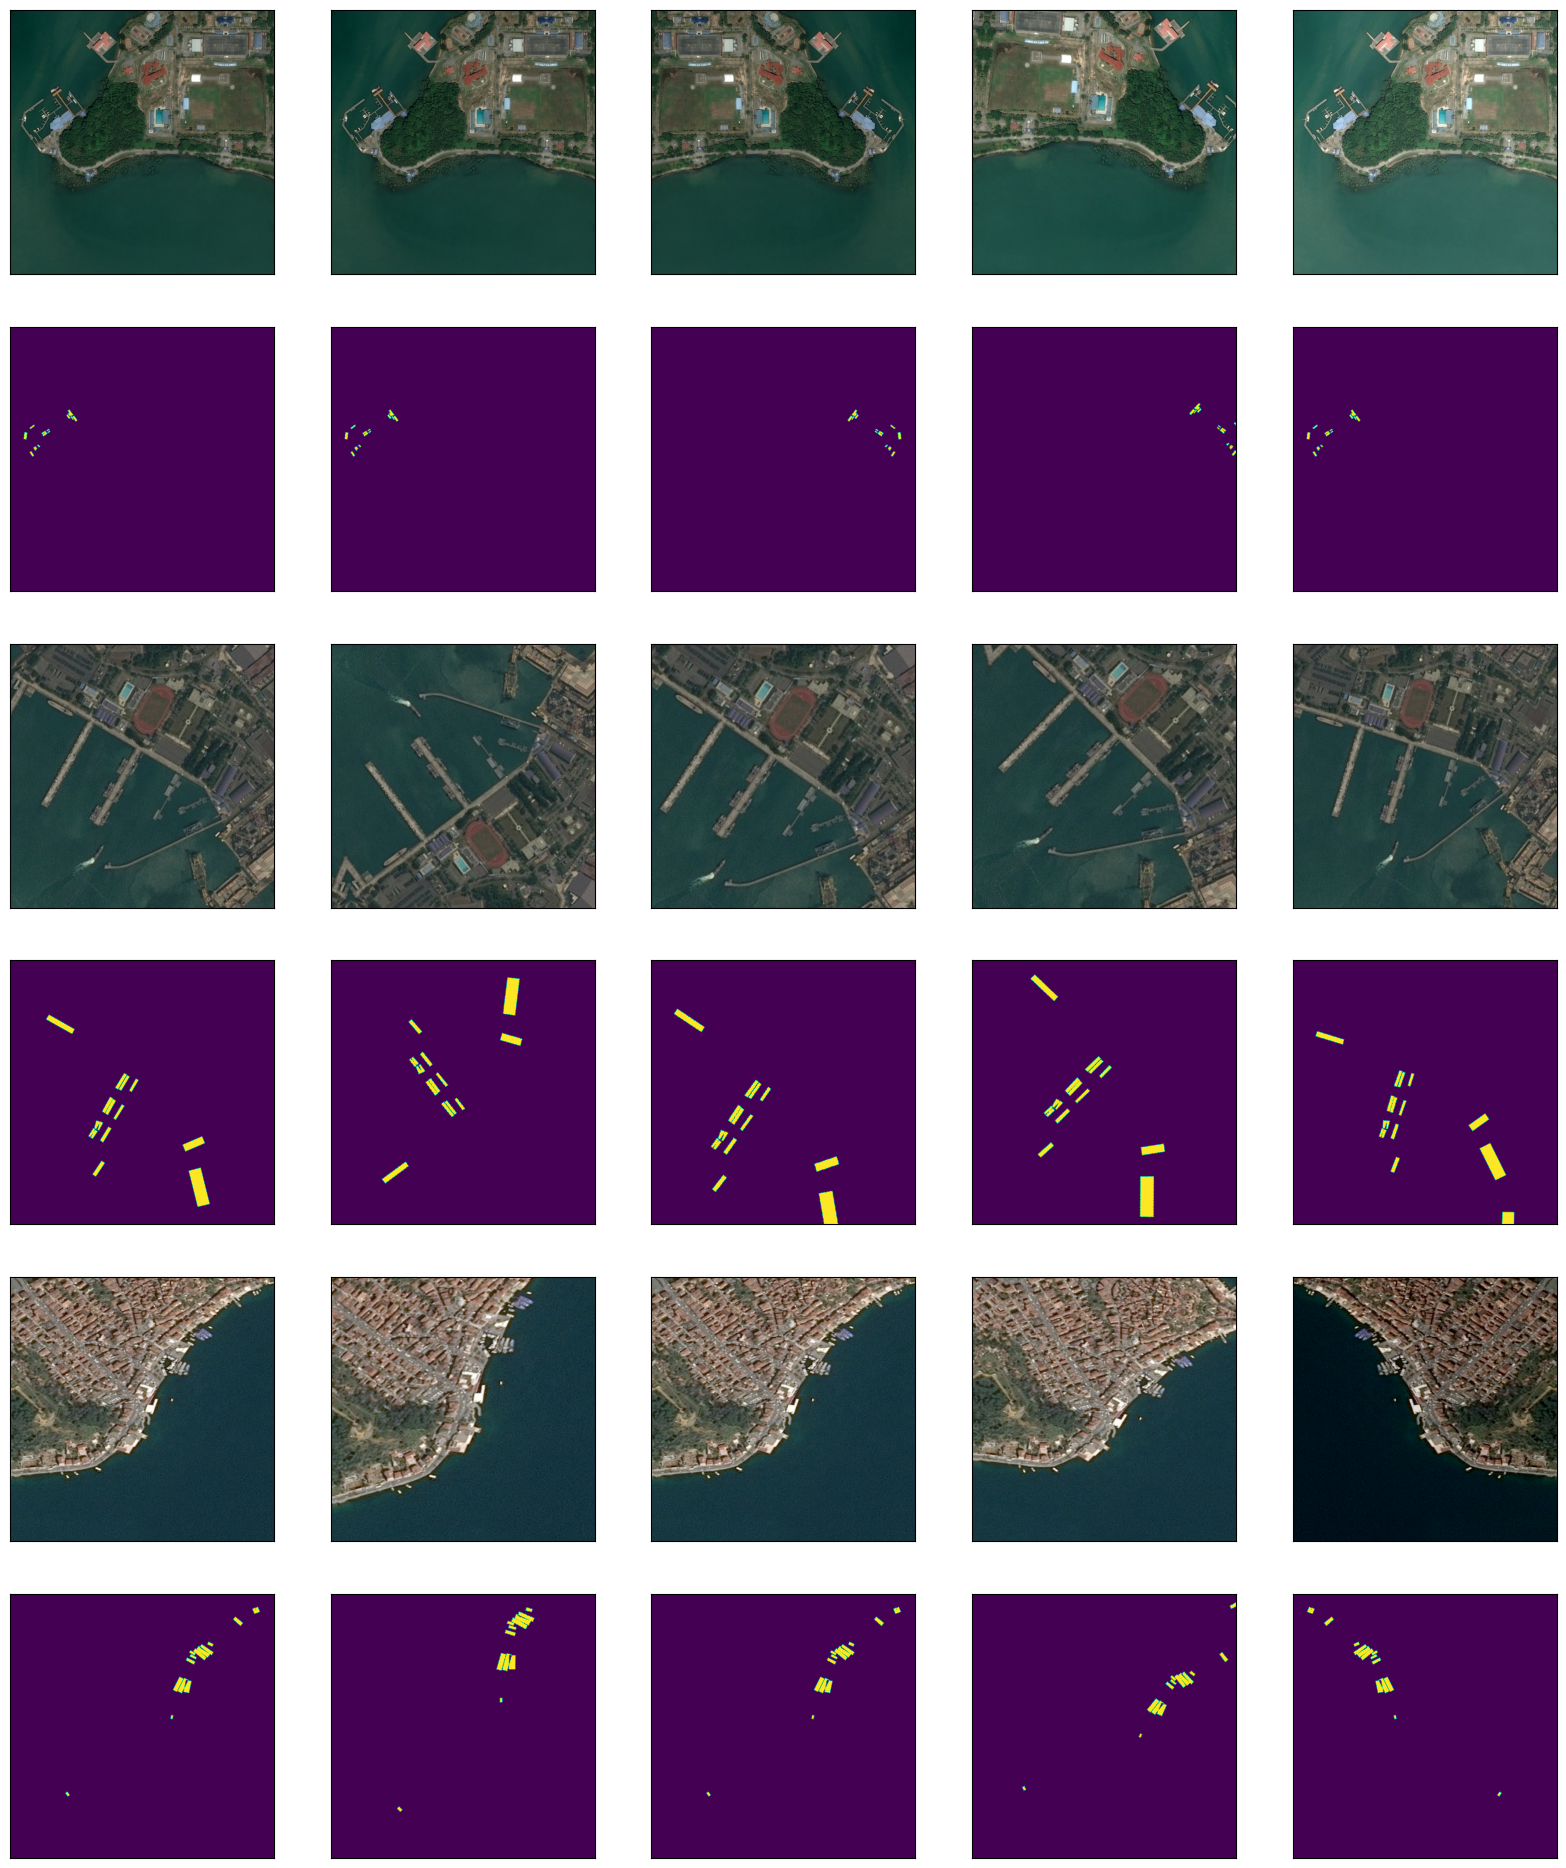

In [41]:
fig = plt.figure(figsize=(20, 24))
num_samples = 3
for i, img_id in enumerate(list(num_objects_df.sort_values('IsObject', ascending=False)['ImageId'].unique())[:num_samples]):
    img = cv2.imread(str(DS_DIR/'train_v2'/img_id))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    mask = get_mask(img_id)
    
    ax = fig.add_subplot(6, 5, 5*i*2+1, xticks=[], yticks=[])
    ax.imshow(img)
    ax = fig.add_subplot(6, 5, 5*(i*2+1)+1, xticks=[], yticks=[])
    ax.imshow(mask)

    for a in range(4):
        augs = transform(image=img, mask=mask)
        aug_img = augs['image']
        aug_mask = augs['mask']
        ax = fig.add_subplot(6, 5, 5*i*2+1+(a+1), xticks=[], yticks=[])
        ax.imshow(aug_img)
        ax = fig.add_subplot(6, 5, 5*(i*2+1)+1+(a+1), xticks=[], yticks=[])
        ax.imshow(aug_mask)
plt.show()

Looks nice.

In the next part I shuffle dataset and split into train and validation parts. 

In [ ]:
unique_ids = train_df['ImageId'].unique()
np.random.shuffle(unique_ids)
train_ids = unique_ids[:int(len(unique_ids) * 0.8)]
val_ids = unique_ids[int(len(unique_ids) * 0.8):int(len(unique_ids) * 1.0)]

In [ ]:
train_df.head()

ImageId                                      EncodedPixels
0  00003e153.jpg                                                NaN
1  0001124c7.jpg                                                NaN
2  000155de5.jpg  264661 17 265429 33 266197 33 266965 33 267733...
3  000194a2d.jpg  360486 1 361252 4 362019 5 362785 8 363552 10 ...
4  000194a2d.jpg  51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...

In [ ]:
train_metadata = train_df[train_df['ImageId'].isin(train_ids)].reset_index(drop=True)
val_metadata = train_df[train_df['ImageId'].isin(val_ids)].reset_index(drop=True)